# Solving the equation: $ u_{xx} + au_x + bu + cx = 0$

# for $ a = -10, b = 9$ and $c = -5$

# with initial conditions: 
* # $u(0) = -1$
* # $u_x(0) = 2$

# Exact solution: $ u(t) = \frac{50}{81} + \frac{5}{9}t + \frac{31}{81}e^{9t} - 2e^t$ 

# Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from google.colab import files
from tqdm.auto import tqdm
from datetime import datetime 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR

# Helpers

In [53]:
class FeedForward(nn.Module):
  def __init__(self,
               n_layers,
               layers,
               activation=nn.ReLU()):

    super().__init__()
    self.n_layers = n_layers 
    self.layers = layers
    self.activation = activation

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers-1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.feed_forward = nn.Sequential(*dense_layers)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
      self.activation,
    )
    return dense_layer
  
  def forward(self, x):
    return self.feed_forward(x)

In [54]:
class PINN():
  def __init__(self, a, b, c,
               x, x0, u0, z0,
               layers, n_layers,
               epochs, patience,
               optimizer,
               chkpt_path='model.pth',
               lr=1e-3,
               weight_decay=0,
               activation=nn.ReLU(),
               dtype=torch.float32,
               device='cpu'):
    
    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.a = torch.tensor(a, dtype=dtype, device=device)
    self.b = torch.tensor(b, dtype=dtype, device=device)
    self.c = torch.tensor(c, dtype=dtype, device=device)
    self.x = torch.tensor(x, dtype=dtype, device=device, requires_grad=True)
    self.x0 = torch.tensor(x0, dtype=dtype, device=device, requires_grad=True)
    self.u0 = torch.tensor(u0, dtype=dtype, device=device)   
    self.z0 = torch.tensor(z0, dtype=dtype, device=device) 
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience

    # Neural network
    self.feed_forward = FeedForward(n_layers=n_layers,
                                      layers=layers,
                                      activation=activation)
    # Setting optimizer and scheduler
    if optimizer == 'Adam':
      self.optimizer = torch.optim.Adam(lr=lr, params=self.feed_forward.parameters(), weight_decay=weight_decay)

  def calculate_u(self, x):
    return self.feed_forward(x)
  
  def calculate_f(self, x):
    u = self.calculate_u(x)

    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x, 
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    f_hat = u_xx + self.a * u_x + self.b * u + self.c * x
    return u[0], u_x[0], f_hat
  
  def loss_fn(self):
    u0_hat, z0_hat, f_hat = self.calculate_f(self.x.view(-1, 1))
    loss = 0.01 * torch.mean(f_hat ** 2) + (self.u0 - u0_hat) ** 2 + (self.z0 - z0_hat) ** 2
    return loss

  def train_step(self):
    self.feed_forward.train()
    loss = 0
    batch_loss = self.loss_fn()
    loss += batch_loss.item()
    self.optimizer.zero_grad()
    batch_loss.backward()
    self.optimizer.step()
    return loss

  def train(self):
    t0 = pd.Timestamp.now()

    losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0
      loss = self.train_step()
      losses.append(loss)

      if epoch == 0:
        best_val_loss = loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss: {loss}- *Checkpoint*")
      else:
        if loss < best_val_loss:
          best_val_loss = loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % 100 == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss: {loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % 100 == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % 100 == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss: {loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())
    
    return losses

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

  def predict(self, x):
    t0 = datetime.now()
    x = torch.tensor(x[:, 0], dtype=self.dtype, device=self.device, requires_grad=True).float()
    self.feed_forward.eval()
    u = self.calculate_u(x.view(-1, 1))
    f, _, _ = self.calculate_f(x.view(-1, 1))
    u = u.detach().cpu().numpy()
    f = f.detach().cpu().numpy()
    print(f"TOTAL INFERENCE TIME: ")
    self.timer(t0, datetime.now())
    return u, f

# MAIN

In [55]:
X_MIN, X_MAX, N_X = 0, 0.25, int(500)
a, b, c = -10, 9, -5

# **************  Create Training data **************
x = torch.linspace(X_MIN, X_MAX, N_X).view(-1, 1)
x0 = torch.tensor([0.], dtype = torch.float32)

# Boundary Conditions
u0 = torch.tensor([-1.], dtype = torch.float32)
z0 = torch.tensor([2.], dtype = torch.float32)

# TRAIN

In [56]:
EPOCHS = int(10000)
LAYERS = [1, 50, 50, 50, 1]
N_LAYERS = len(LAYERS) - 1
PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pinn = PINN(
    a=a, b=b, c=c,
    x=x, x0=x0, u0=u0, z0=z0,
    layers=LAYERS, 
    n_layers=N_LAYERS,
    epochs=EPOCHS,
    patience=EPOCHS+1,
    optimizer='Adam',
    lr=1e-3,
    weight_decay=0,
    activation=nn.Tanh()
)

loss = pinn.train()

<ipython-input-54-b2d7649650f3>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=dtype, device=device, requires_grad=True)
<ipython-input-54-b2d7649650f3>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x0 = torch.tensor(x0, dtype=dtype, device=device, requires_grad=True)
<ipython-input-54-b2d7649650f3>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u0 = torch.tensor(u0, dtype=dtype, device=device)
<ipython-input-54-b2d7649650f3>:25: UserWarning: To copy construct from a tensor, it is recomme

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/10000 | Loss: 5.578840255737305- *Checkpoint*
Epoch: 101/10000 | Loss: 2.8824689388275146 - *Checkpoint*
Epoch: 201/10000 | Loss: 2.8412604331970215 - *Checkpoint*
Epoch: 301/10000 | Loss: 2.7274301052093506 - *Checkpoint*
Epoch: 401/10000 | Loss: 2.528764486312866 - *Checkpoint*
Epoch: 501/10000 | Loss: 0.027602285146713257
Epoch: 601/10000 | Loss: 0.0008710704278200865 - *Checkpoint*
Epoch: 701/10000 | Loss: 0.0006682290113531053 - *Checkpoint*
Epoch: 801/10000 | Loss: 0.0005172968376427889 - *Checkpoint*
Epoch: 901/10000 | Loss: 0.00040284774149768054 - *Checkpoint*
Epoch: 1001/10000 | Loss: 0.00036247808020561934
Epoch: 1101/10000 | Loss: 0.0002487025922164321 - *Checkpoint*
Epoch: 1201/10000 | Loss: 0.00019951640570070595 - *Checkpoint*
Epoch: 1301/10000 | Loss: 0.0001624474534764886
Epoch: 1401/10000 | Loss: 0.00012937918654643 - *Checkpoint*
Epoch: 1501/10000 | Loss: 0.013736755587160587
Epoch: 1601/10000 | Loss: 8.629846706753597e-05 - *Checkpoint*
Epoch: 1701/10000 | 

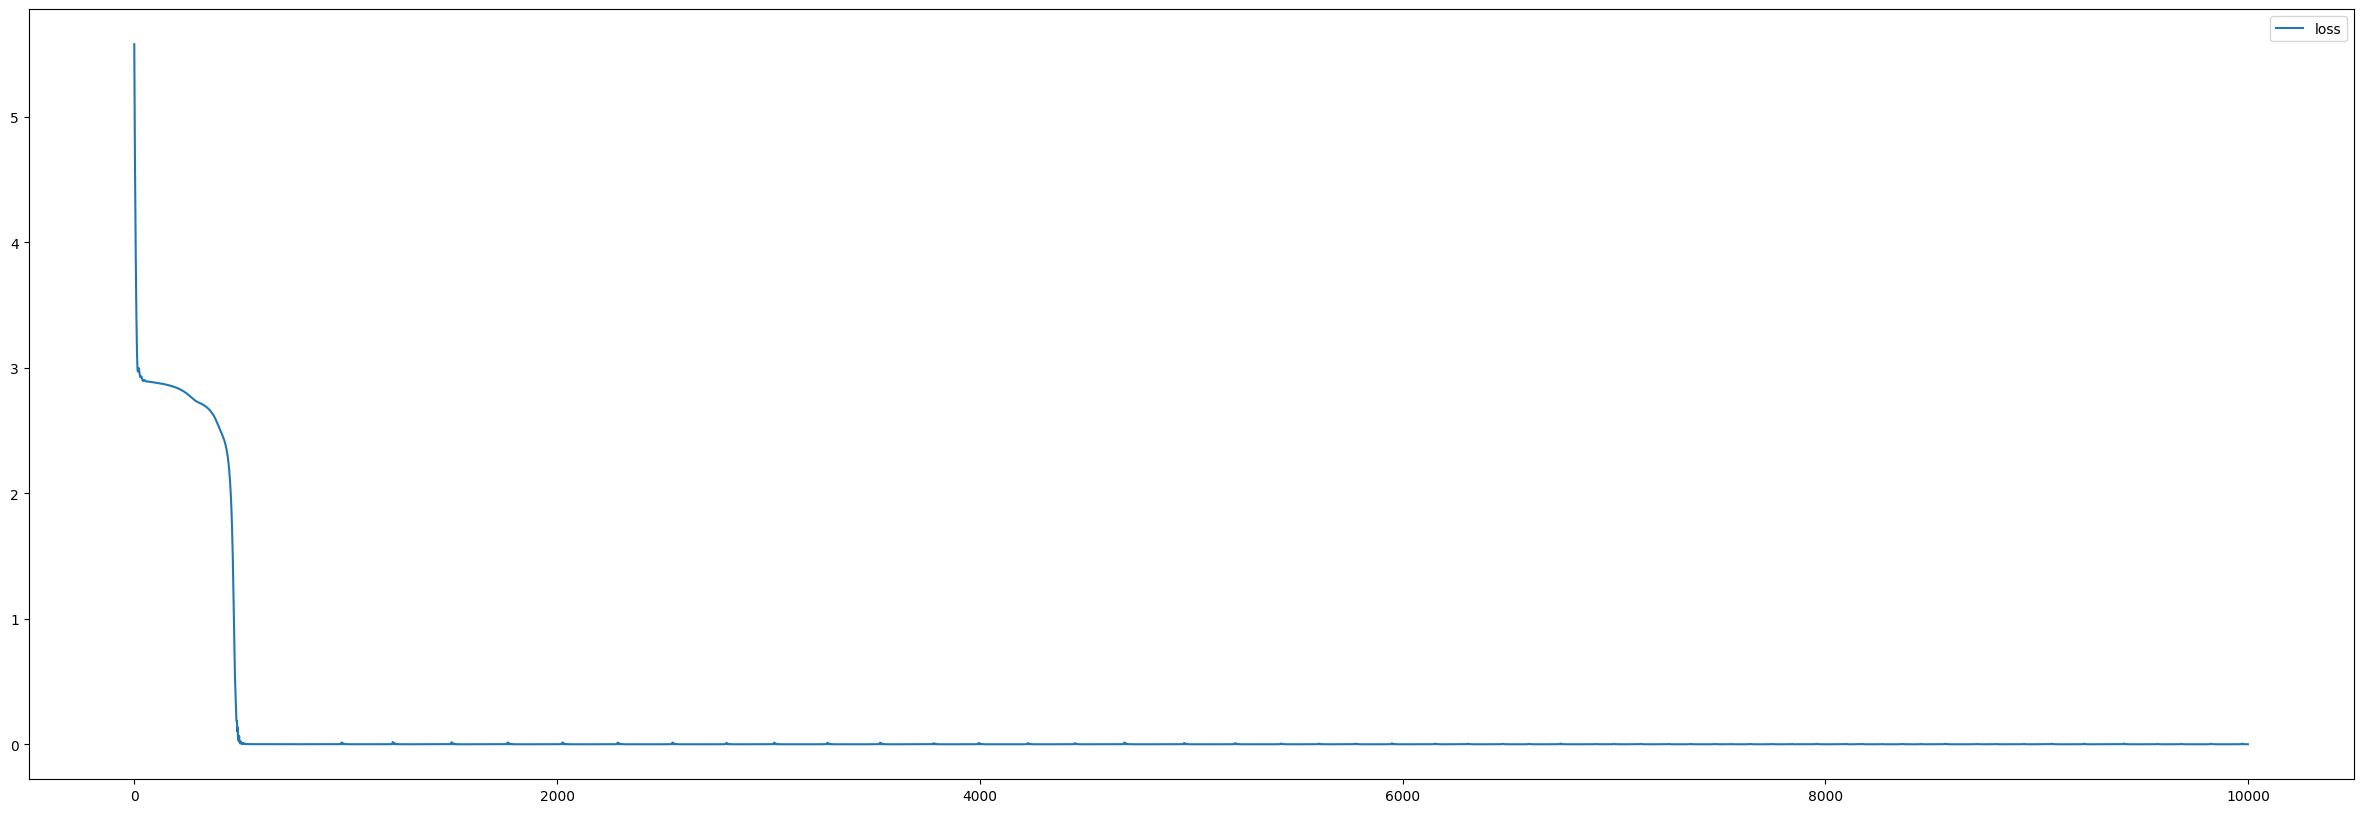

In [57]:
plt.figure(figsize=(30, 10))
plt.plot(loss, label='loss')
plt.legend()
plt.show()

<ipython-input-54-b2d7649650f3>:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x[:, 0], dtype=self.dtype, device=self.device, requires_grad=True).float()


TOTAL INFERENCE TIME: 
00:00:00.00


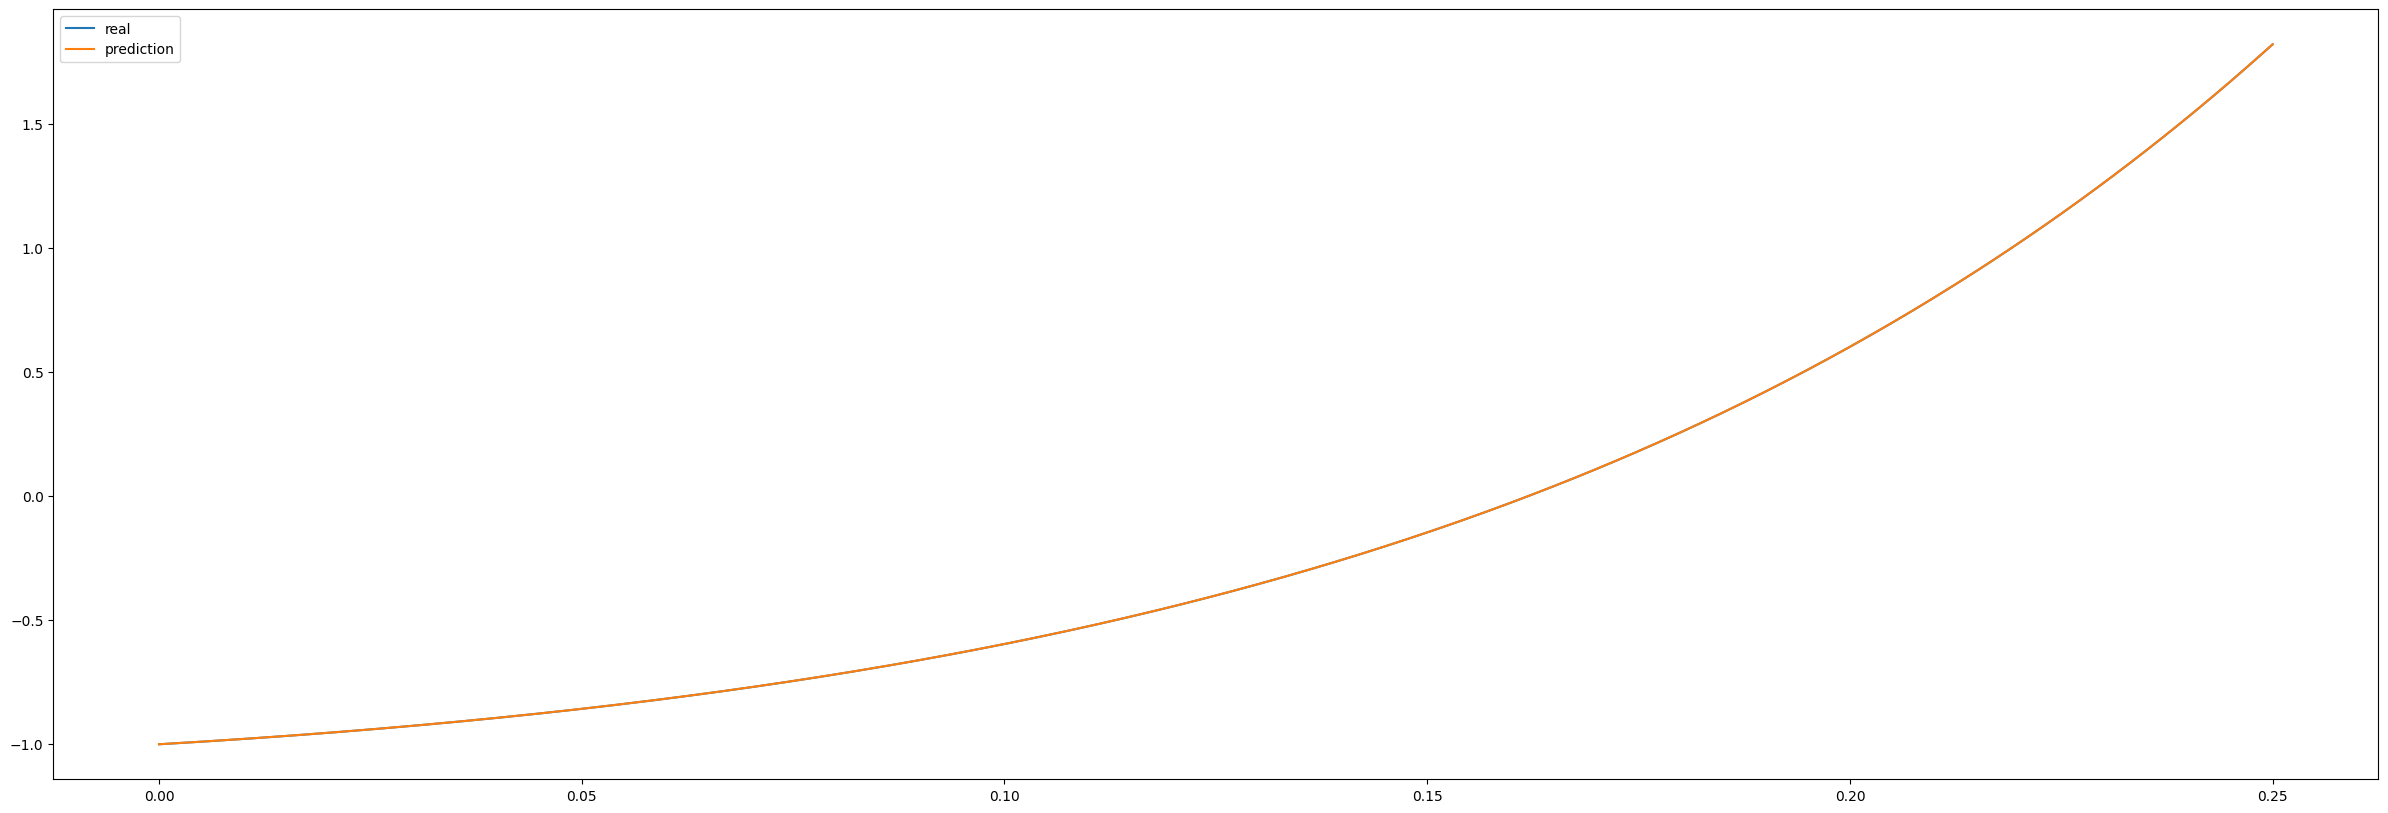

In [60]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

# PINN inference
u_hat, gv_hat = pinn.predict(x)

# Real solution
u = 50/81 + (5/9) * x + (31/81) * torch.exp(9 * x) - 2 * torch.exp(x)

plt.figure(figsize=(30, 10))
plt.plot(x, u, label='real')
plt.plot(x, u_hat.flatten(), label='prediction')
plt.legend(loc='upper left')
plt.show()